# Part 1 - Exploratory data analysis

In [1]:
import json
import pandas as pd

# Load the json file
with open("/Users/paperclip/Documents/MASTER/Data Scientist Springboard/ultimate_challenge/logins.json", "r") as file:
    data = json.load(file)

# Convert it into a DataFrame
df_logins = pd.DataFrame(data)

# Convert login_time to datetime
df_logins['login_time'] = pd.to_datetime(df_logins['login_time'])

# Set it as the index
df_logins.set_index('login_time', inplace=True)

# Add a column representing "number of logins" and set all to 1 as each row is a login
df_logins['count'] = 1


In [2]:
#Show the first 10 lines of data, show dataset dimension
df_logins.head(10), df_logins.shape

(                     count
 login_time                
 1970-01-01 20:13:18      1
 1970-01-01 20:16:10      1
 1970-01-01 20:16:37      1
 1970-01-01 20:16:36      1
 1970-01-01 20:26:21      1
 1970-01-01 20:21:41      1
 1970-01-01 20:12:16      1
 1970-01-01 20:35:47      1
 1970-01-01 20:35:38      1
 1970-01-01 20:47:52      1,
 (93142, 1))

The login_time is not in an increasing order, which could be resulted from different reasons. 

In [7]:
# Check for any missing values
missing_values_count = df_logins.isnull().sum()
print("Missing Values Count:", missing_values_count,"\n")

# Check if all timestamps are in the correct format and make sense
# This is more of a manual examination, looking at random samples or summaries.
print(df_logins.index.year.unique())  # Check for unexpected years
print(df_logins.index.month.unique())  # Check for unexpected months



Missing Values Count: count    0
dtype: int64 

Index([1970], dtype='int32', name='login_time')
Index([1, 2, 3, 4], dtype='int32', name='login_time')


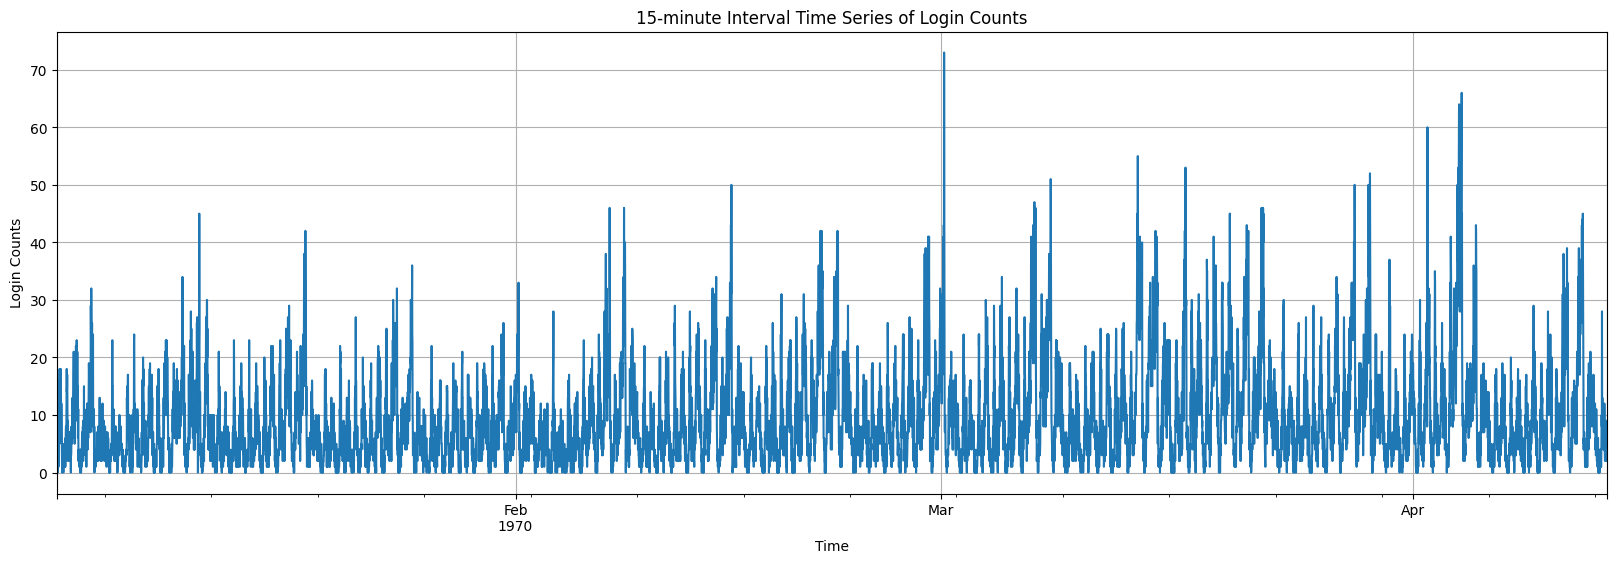

In [8]:
import matplotlib.pyplot as plt
# Resample data into 15 minute bins and sum the counts
df_logins_15T = df_logins.resample('15T').sum()

# Plotting the time series of login counts
plt.figure(figsize=(20,6))
df_logins_15T['count'].plot()
plt.title('15-minute Interval Time Series of Login Counts')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.grid(True)
plt.show()

There are fluctuations in login counts, indicating variability in usage throughout the time period captured in the data.
There seem to be patterns that could correspond to daily cycles.


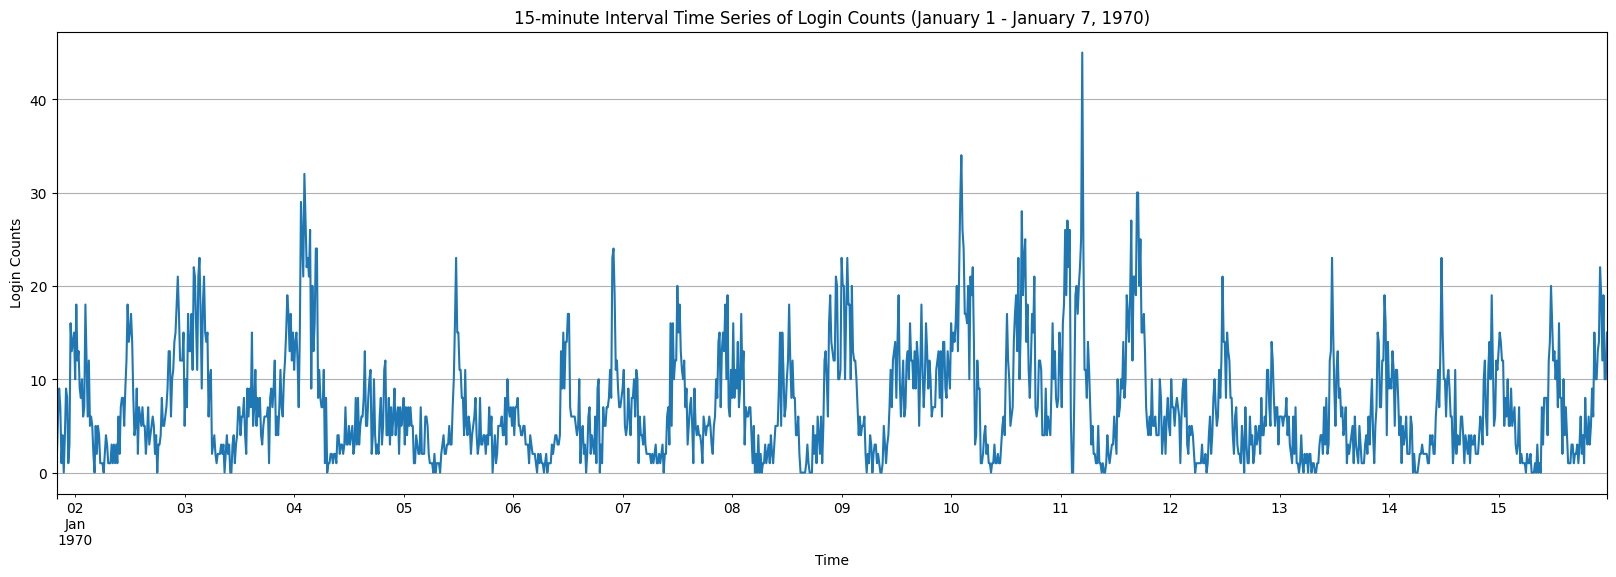

In [17]:
# Define the date range for the plot
start_date = '1970-01-01'
end_date = '1970-01-15'

# Filter the DataFrame for the selected date range
df_logins_15T_selected = df_logins_15T.loc[start_date:end_date]

# Plotting the time series of login counts for the selected period
plt.figure(figsize=(20,6))
df_logins_15T_selected['count'].plot()
plt.title('15-minute Interval Time Series of Login Counts (January 1 - January 7, 1970)')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.grid(True)
plt.show()





The plot appears noisy. A one hour resample will be applied to the data instead of 15 minutes.

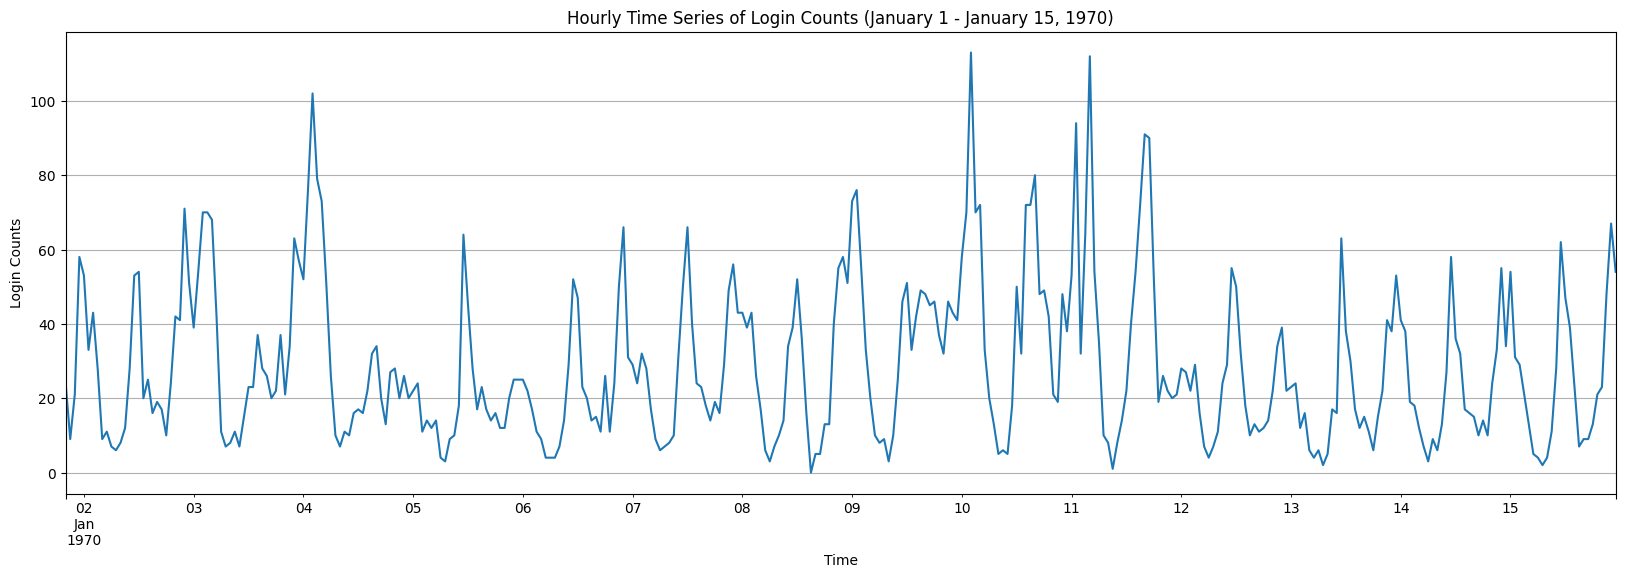

In [18]:
# Resample data into 1-hour bins and sum the counts
df_logins_hourly_selected = df_logins.resample('H').sum().loc[start_date:end_date]

# Plotting the time series of login counts for the selected period
plt.figure(figsize=(20,6))
df_logins_hourly_selected['count'].plot()
plt.title('Hourly Time Series of Login Counts (January 1 - January 15, 1970)')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.grid(True)
plt.show()



There are typically two peaks at 12pm noon and 0am midnight every day. 

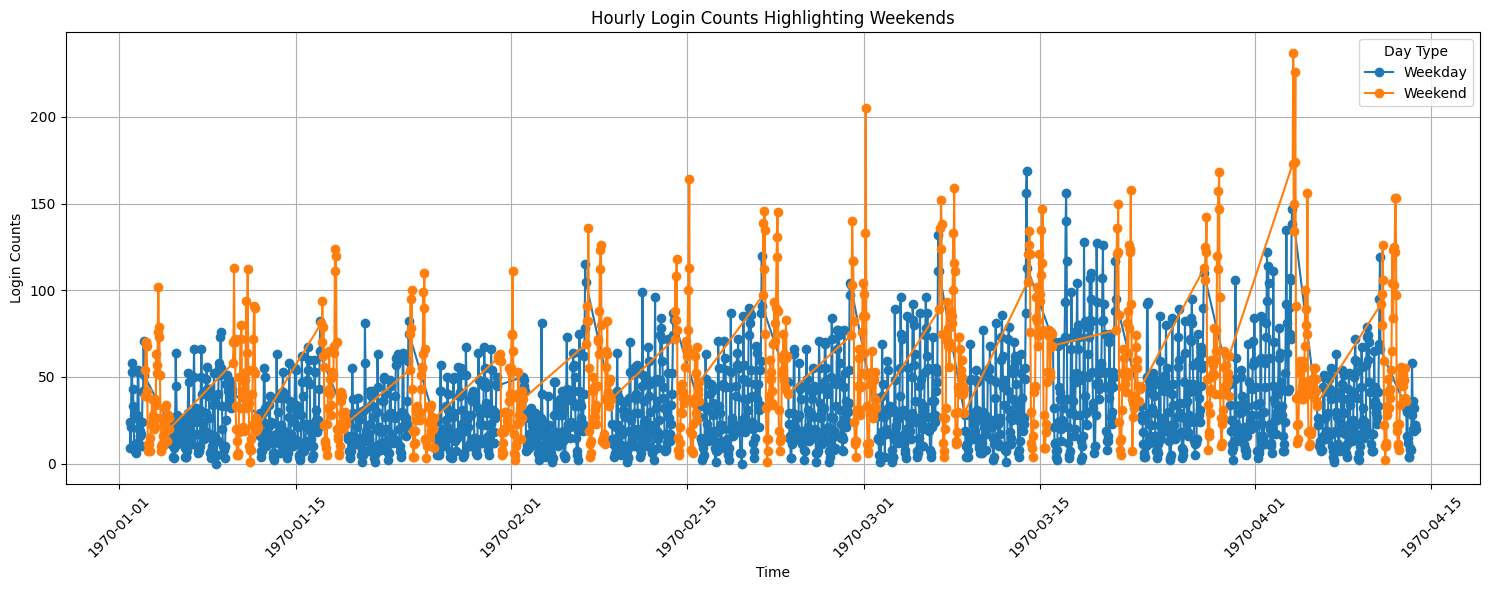

In [11]:
# Check if 'login_time' is in the DataFrame and convert it to datetime
if 'login_time' in df_logins.columns:
    df_logins['login_time'] = pd.to_datetime(df_logins['login_time'])
    df_logins.set_index('login_time', inplace=True)
elif not isinstance(df_logins.index, pd.DatetimeIndex):
    raise ValueError("DataFrame is not structured as expected with 'login_time' as a datetime index.")

# Add a column representing "number of logins" and set all to 1 as each row is a login
df_logins['count'] = 1

# Resampling the data into 1-hour bins and summing the counts
df_logins_hourly = df_logins.resample('H').sum()

# Add a column for day of week (0 = Monday, 6 = Sunday)
df_logins_hourly['day_of_week'] = df_logins_hourly.index.dayofweek

# Define a function to apply color for weekends
def apply_color_for_weekends(day):
    if day in [5, 6]:  # 5 = Saturday, 6 = Sunday
        return "Weekend"
    else:
        return "Weekday"

# Apply color to each day based on whether it is a weekday or weekend
df_logins_hourly['type_of_day'] = df_logins_hourly['day_of_week'].apply(apply_color_for_weekends)

# Plotting with matplotlib
plt.figure(figsize=(15, 6))
for day_type, group in df_logins_hourly.groupby('type_of_day'):
    plt.plot(group.index, group['count'], marker='o', linestyle='-', label=day_type)

plt.title('Hourly Login Counts Highlighting Weekends')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.xticks(rotation=45)
plt.legend(title='Day Type')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()




The number of daily logins at weekend are generally higher than the number of daily logins at weekday. 

From the above graph, it is clear that daily login count at weekend is typicaly higher than the count in weekday.

In [14]:
# Ensure you have the df_logins DataFrame defined as before
# Convert it into an hourly time frame from the 15-minute intervals or directly from the original data
df_logins_hourly = df_logins.resample('H').sum()

# Adding a day of the week column
df_logins_hourly['day_of_week'] = df_logins_hourly.index.dayofweek  # Monday=0, Sunday=6

# Calculate average logins for weekdays (Monday=0, ..., Friday=4) and weekends (Saturday=5, Sunday=6)
weekday_avg = df_logins_hourly[df_logins_hourly['day_of_week'] < 5]['count'].mean()
weekend_avg = df_logins_hourly[df_logins_hourly['day_of_week'] >= 5]['count'].mean()

print("Average logins during weekdays: ", weekday_avg)
print("Average logins during weekends: ", weekend_avg)


Average logins during weekdays:  32.19339895773017
Average logins during weekends:  52.144444444444446


The graph shows that the login reaches peak during the weekend.

# Part 2 ‐ Experiment and metrics design

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

A primary measure of success can be the increase in the ratio or percentage of cross-city trips to total trips. If the experiment is successful, we would expect more drivers to cross the bridge, serving both cities, leading to a higher proportion of trips that start in one city and end in the other. This metric directly reflects the behavior change the experiment aims to influence.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

a) Pre-reimbursement period - collect data on each driver's trip, including both in the city and cross the city. Then start reimbursing toll costs for a set period, clearly communicating the policy change to the driver. Post-reimbursement period, continue collect data on each driver's trip, including both in the city and cross the city. Also take note of all the cost associated with reimbursing toll costs

b)Statistical test 

b.1 Ratio comparison before and after the reimbursing toll costs. Use a paired sample t-test to compare the average ratio of cross-city trips before and after the toll reimbursement starts for the same group of drivers. This test is appropriate if the data is normally distributed; if not, consider a non-parametric equivalent like the Wilcoxon signed-rank test.

b.2 Ratio comparison between the control group and experiment group. Select two groups of drivers including a control group of drivers who do not receive toll reimbursement to and  an experimental group that does. This setup allows for an A/B testing approach, comparing the change in cross-city trips between groups using a two-sample t-test (or its non-parametric equivalent if the data is not normally distributed).

c) Results and recommendations

c.1 If there's a statistically significant increase in the ratio of cross-city trips, the experiment can be considered successful. Recommend full implementation of toll reimbursement with continuous monitoring of the metric.

c.2 If there's no significant change or a decrease, then take a look at feedback from drivers and issues with the experiment's implementation.

c.3 Calculate finacial gain by measuring revenue - toll reimbursement cost, then check whether there is an increase of revenue before and after the policy implementation AND whether there is an increase of revenue comparing two groups of drivers

c.4 Evaluate the impact of noise factors on the results

# Part 3 ‐ Predictive modeling

In [19]:
# First, let's load the data and start working with it using Python
import json
import pandas as pd

# Load the json file
with open("/Users/paperclip/Documents/MASTER/Data Scientist Springboard/ultimate_challenge/ultimate_data_challenge.json", "r") as file:
    data = json.load(file)

# Convert it into a DataFrame
df_city = pd.DataFrame(data)

# Convert signup_date to datetime
df_city['signup_date'] = pd.to_datetime(df_city['signup_date'])

# Convert last_trip_date to datetime
df_city['last_trip_date'] = pd.to_datetime(df_city['last_trip_date'])

In [35]:
df_city.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_day,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,25,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,29,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,6,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,10,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,27,0


In [20]:
# Check for any missing values
missing_values_count = df_city.isnull().sum()
print("Missing Values Count:", missing_values_count,"\n")


Missing Values Count: city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64 



In [22]:
# Data Cleaning
# Calculate the mean of the column
mean_value=df_city['avg_rating_of_driver'].mean()
# Fill NA/NaN values in 'column_name' using the calculated mean
df_city['avg_rating_of_driver'].fillna(value=mean_value, inplace=True)

# Drop rows with any column having NA/null data
df_city = df_city.dropna()

# Check for duplicate entries
duplicate_entries = df_city.duplicated().sum()
print("Duplicate Entries: ", duplicate_entries)

# Drop duplicated rows
df_city=df_city.drop_duplicates()

Duplicate Entries:  8


In [28]:
# Ratio of the drivers that has last trip in June divided by the total number of drivers
Ratio = (df_city['last_trip_date'].dt.month==6).sum()/49398
print("Retained rate: {:.2%}".format(Ratio))

Retained rate: 36.62%


Therefore, about 36.62% of users started in January are retained. 

In [31]:
#Create a new column "signup_dat" from the day information of the "signup_date" column
df_city['signup_day']=df_city['signup_date'].dt.day
# Create a new column 'is_june' with 1 if month is June, else 0; according to the instruction, 1 means user is retained
df_city['retained'] = df_city['last_trip_date'].dt.month.apply(lambda x: 1 if x == 6 else 0)
df_city.drop(['signup_date','last_trip_date'], inplace=True, axis=1)

KeyError: 'signup_date'

In [30]:
# Displaying data types of all columns
column_data_types = df_city.dtypes

# classify each column into either categorical or numerical column
categorical_columns = []
numerical_columns = []

for column, dtype in column_data_types.items():
    if dtype == 'object' or dtype =='bool':
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

# Print the results
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['city', 'phone', 'ultimate_black_user']

Numerical Columns:
['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'signup_day', 'retained']


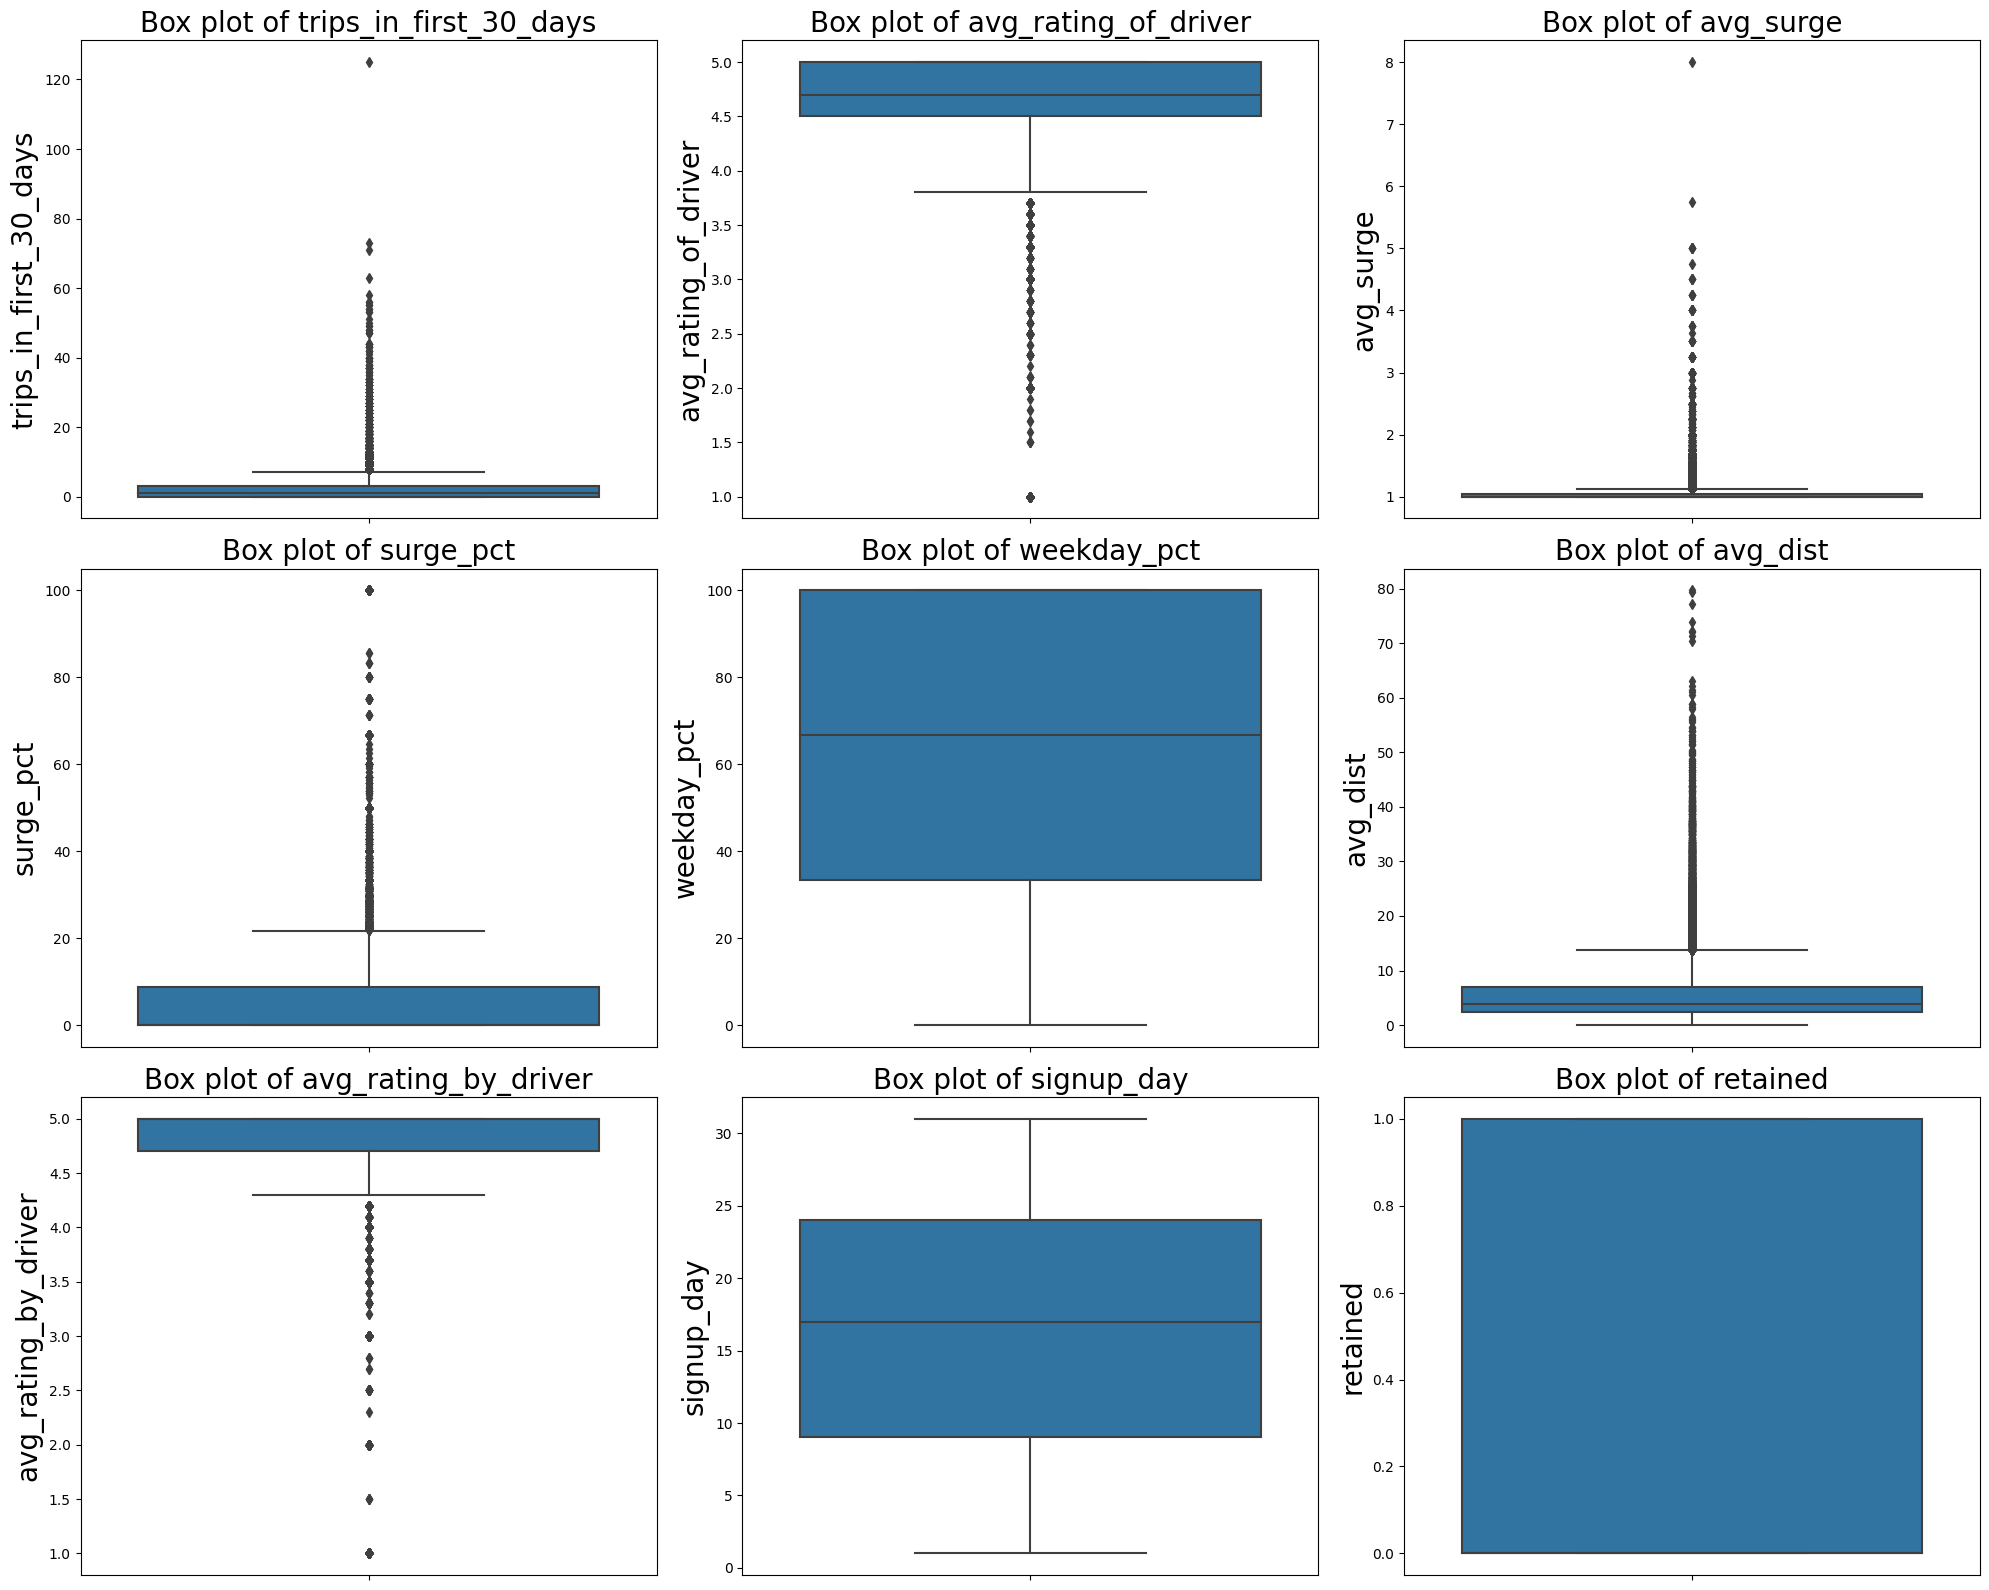

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 4x5 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 16)) # Adjust figure size as needed
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration


# Create box plots for each numerical column
for i, column in enumerate(numerical_columns):
    sns.boxplot(y=df_city[column], ax=axes[i])
    axes[i].set_title(f'Box plot of {column}', fontsize=20)
    axes[i].set_ylabel(column, fontsize=20)

# If there are more subplots than variables, remove the empty plots
for ax in axes[i+1:]:
    ax.remove()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


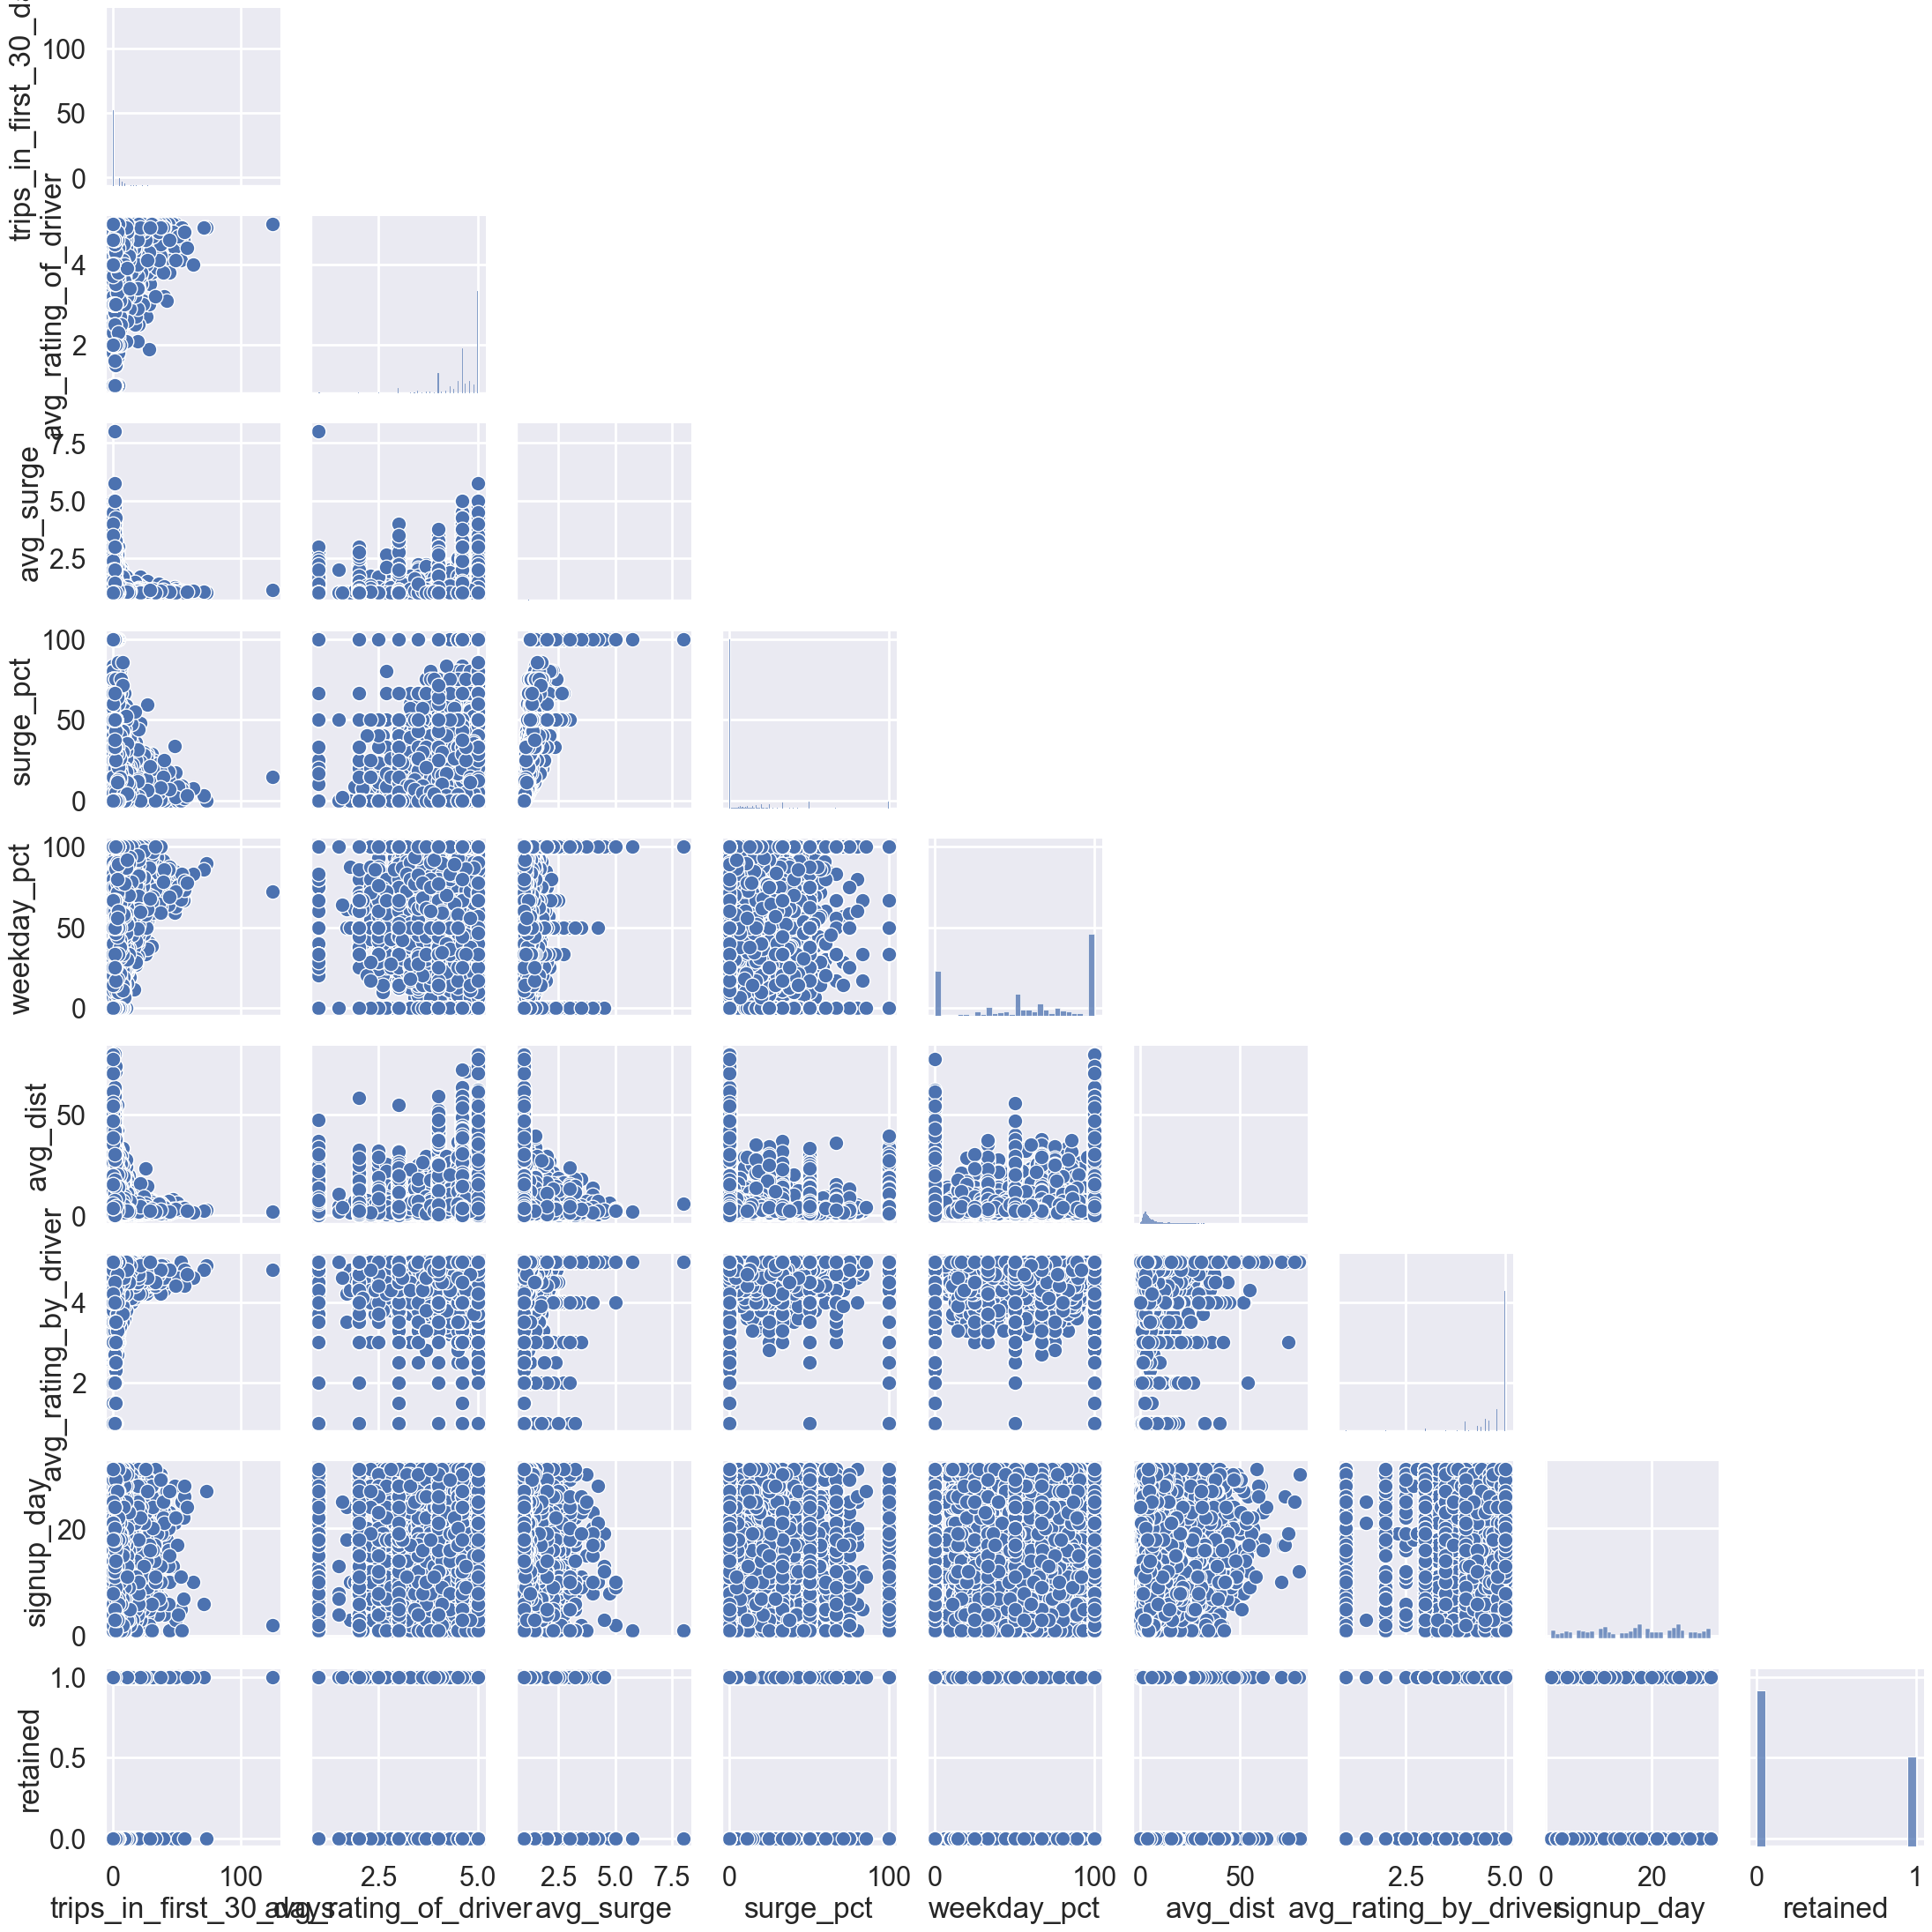

In [33]:
# Plotting
sns.set(rc={'figure.figsize':(12,8.279)})
sns.set_context("poster")
pair_plot=sns.pairplot(df_city[numerical_columns])

# Create a mask for the upper triangle
for i in range(len(pair_plot.axes)):  # Loop through rows (i)
    for j in range(i+1, len(pair_plot.axes)):  # Loop through columns (j), starting from i+1
        pair_plot.axes[i, j].set_visible(False)  # Hide upper triangle

        
plt.show()

<Axes: >

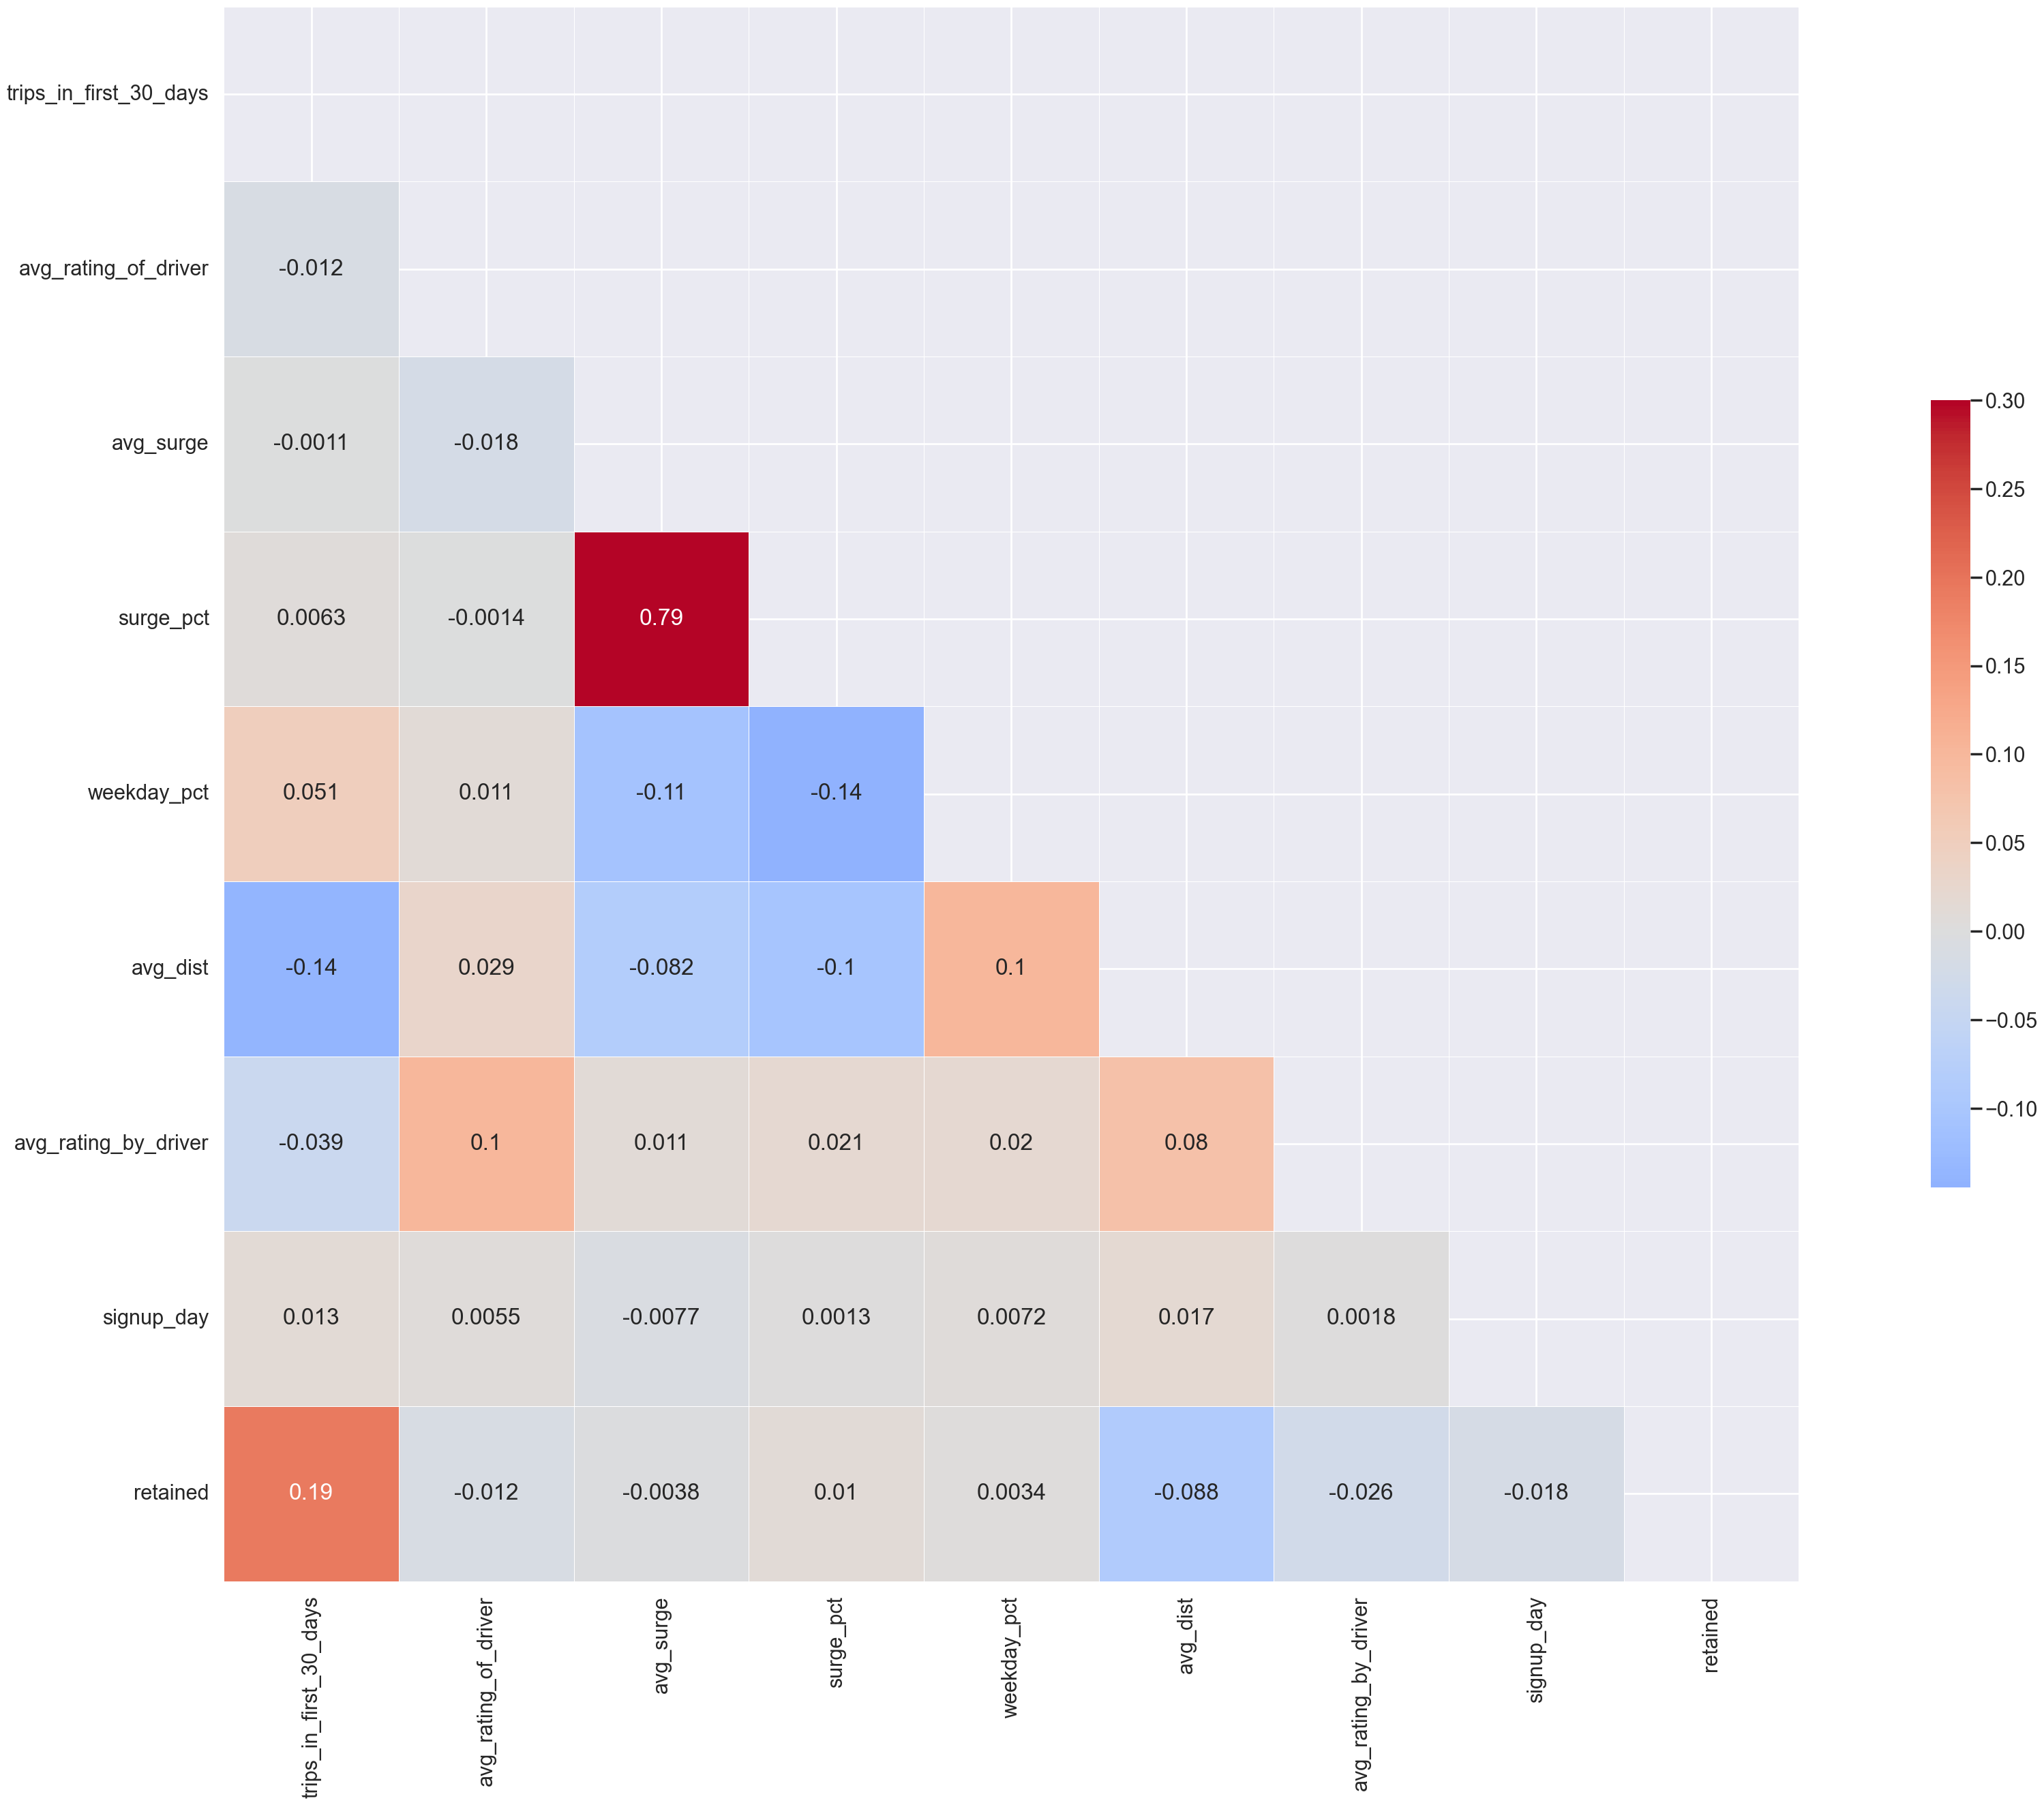

In [34]:
import numpy as np

# Make a heatmap of the data
plt.figure(figsize=(50,30))
sns.set_context("poster")
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(df_city[numerical_columns].corr(), dtype=bool))
#sns.heatmap(car_data[selected_features].corr(),annot=True)

sns.heatmap(df_city[numerical_columns].corr(),mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

surge_pct has a strong positive correlation with avg_surge (0.79), which is indicated by the dark red square. retained has a moderately negative correlation with avg_dist (-0.088), indicated by the dark blue square. trips_in_first_30_days seems to have a relatively strong positive correlation with retained (0.19), suggesting that riders with more trips in the first 30 days are more likely to be retained. avg_dist (average distance) has a negative correlation with retained, suggesting that riders who travel longer distances are less likely to be retained.
logistic regression is used for binary classification tasks, which is a good baseline model because it's simple and interpretable. It assumes linear relationships, so it might not perform best if the relationships are non-linear.
Random Forest or Gradient Boosting Machines (like XGBoost, LightGBM) are ensemble methods that use multiple decision trees to make a prediction. They often perform better than a single decision tree, especially on more complex datasets, because they can capture non-linear relationships and interactions between variables.
Support Vector Machines (SVM): SVMs can model non-linear relationships using the kernel trick and can be quite powerful for binary classification tasks.

Logistic Regression:
Best parameters: {'classifier__C': 10}
Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7743
           1       0.66      0.46      0.55      4607

    accuracy                           0.71     12350
   macro avg       0.70      0.66      0.67     12350
weighted avg       0.70      0.71      0.70     12350



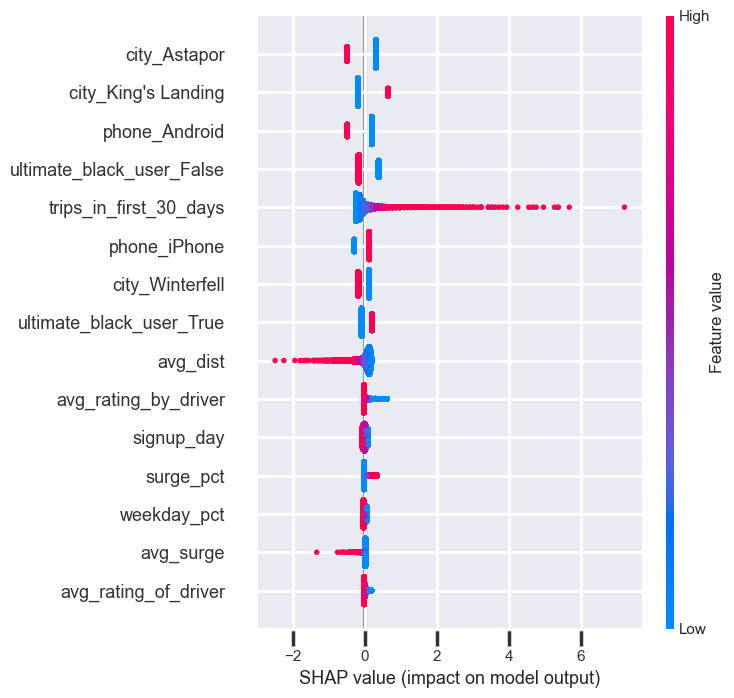


Random Forest:
Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      7743
           1       0.73      0.62      0.67      4607

    accuracy                           0.77     12350
   macro avg       0.76      0.74      0.75     12350
weighted avg       0.77      0.77      0.77     12350



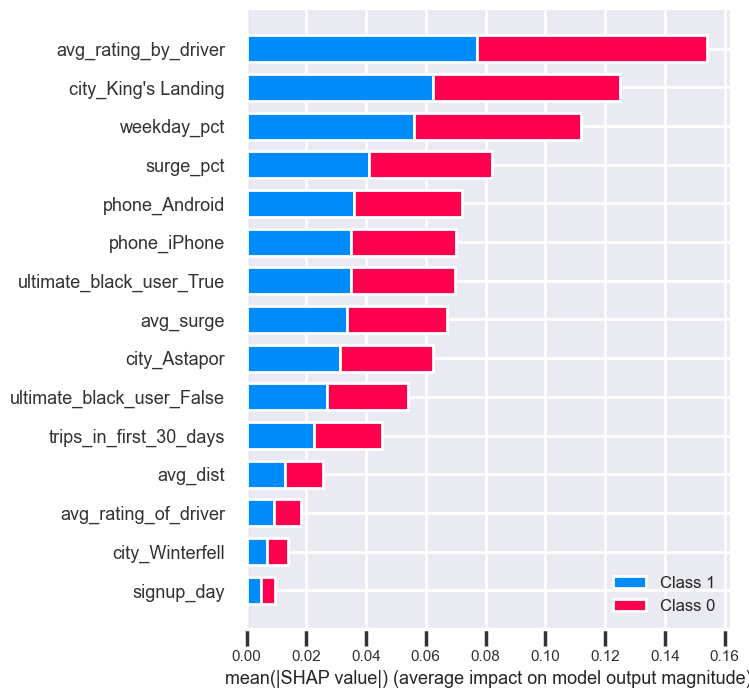


Support Vector Machine:
Best parameters: {'classifier__C': 1, 'classifier__gamma': 'scale'}
Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      7743
           1       0.73      0.56      0.63      4607

    accuracy                           0.76     12350
   macro avg       0.75      0.72      0.73     12350
weighted avg       0.75      0.76      0.75     12350



PermutationExplainer explainer: 51it [08:10, 10.01s/it]


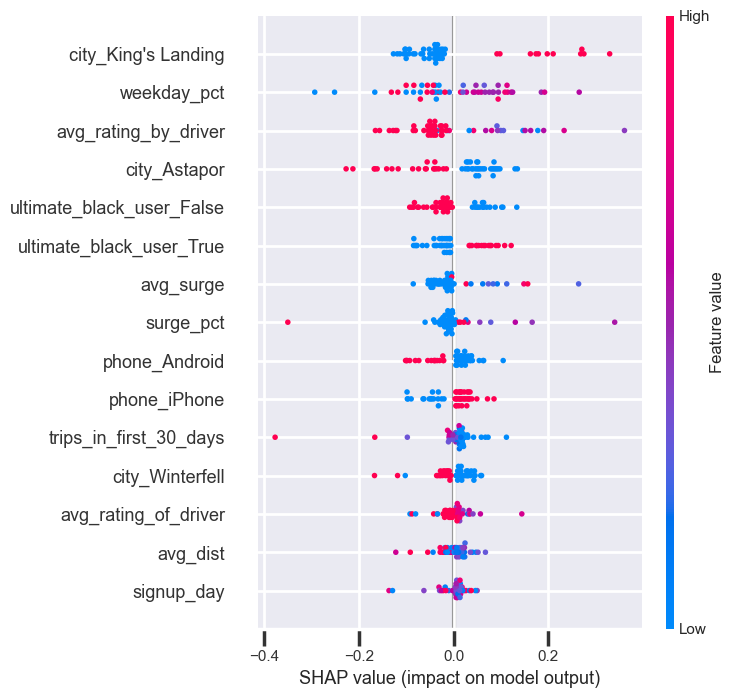

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# df_city is your DataFrame and 'retained' is the target variable
categorical_columns = ['city', 'phone', 'ultimate_black_user']
X = df_city.drop('retained', axis=1)
y = df_city['retained']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Preprocessing: OneHotEncoder for categorical variables and StandardScaler for numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in X_train.columns if col not in categorical_columns]),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Logistic Regression Pipeline
log_reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(random_state=42))])

# Random Forest Pipeline
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])

# SVM Pipeline
svm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(random_state=42))])

# Hyperparameter tuning (example settings, adjust according to your dataset)
param_grid_log_reg = {
    'classifier__C': [0.1, 1, 10]
}
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto']
}

# Training and evaluating each model
def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_preds = best_model.predict(X_test)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_preds):.2f}")
    print(classification_report(y_test, y_preds))
    return best_model

# Generate feature names from the preprocessor
num_features = [col for col in X_train.columns if col not in categorical_columns]
cat_features = list(best_log_reg.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_columns))

feature_names = num_features + cat_features


# Perform SHAP analysis function
def perform_shap_analysis(model, X_train, X_test, model_name, feature_names):
    shap_values = None

    # Transform the test data
    X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

    # Logic for different models
    if model_name == 'log_reg':
        classifier = model.named_steps['classifier']
        explainer = shap.LinearExplainer(classifier, X_test_transformed)
        shap_values = explainer.shap_values(X_test_transformed)
    
    elif model_name == 'random_forest':
        # Use a smaller subset of your training set for the background distribution
        background_sample = shap.sample(X_train, 50)  # Adjust the sample size as needed
        background_sample_transformed = model.named_steps['preprocessor'].transform(background_sample)
        
        classifier = model.named_steps['classifier']
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_test_transformed)

    elif model_name == 'svm':
        sample_size = 50  # Adjust sample size as appropriate
        X_test_transformed_sample = shap.sample(X_test_transformed, sample_size)
        classifier = model.named_steps['classifier']
        explainer = shap.Explainer(classifier.predict, X_test_transformed_sample)
        shap_values = explainer(X_test_transformed_sample)

#   # Calculate the mean absolute SHAP values for each feature
#     if shap_values is not None:
#         if isinstance(shap_values, list):  # Handling multi-class outputs
#             # Combine the SHAP values from all classes
#             shap_values_combined = np.sum([np.abs(sv) for sv in shap_values], axis=0)
#             mean_abs_shap_values = np.mean(shap_values_combined, axis=0)
#         else:
#             # Handling single output models
#             mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

#         print(f"\nMean Absolute SHAP Values for {model_name.replace('_', ' ').title()}:")
#         for i, name in enumerate(feature_names):
#             # Check and format each value individually
#             value = mean_abs_shap_values[i]
#             value_str = "NaN" if np.isnan(value) else f"{value:.4f}"
#             print(f"{name}: {value_str}")
    # Generate the SHAP summary plot
    if shap_values is not None:
        if model_name != 'svm':
            shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)
        else:
            shap.summary_plot(shap_values.values, X_test_transformed_sample, feature_names=feature_names)
 

# Logistic Regression
print("Logistic Regression:")
best_log_reg = train_and_evaluate_model(log_reg_pipe, param_grid_log_reg, X_train, y_train, X_test, y_test)
perform_shap_analysis(best_log_reg, X_train, X_test, 'log_reg', feature_names)

#Random Forest
print("\nRandom Forest:")
best_rf = train_and_evaluate_model(rf_pipe, param_grid_rf, X_train, y_train, X_test, y_test)
perform_shap_analysis(best_rf, X_train, X_test, 'random_forest', feature_names)

# SVM
print("\nSupport Vector Machine:")
best_svm = train_and_evaluate_model(svm_pipe, param_grid_svm, X_train, y_train, X_test, y_test)
perform_shap_analysis(best_svm, X_train, X_test, 'svm', feature_names)


From the overall accuracy, random forests model and SVM have similar performance, better than logistic regression model. 
From the SHAP value plot for the logstic regression, features including avg_dist and trips_in_first_30_days have a mix of high SHAP values, indicating they are influential in th emodel's predictions and their impact varies greatly depending on the specific context of an individual prediction. 

To improve rider's retension, firstly try to increase the number of trip for the first 30 days, as this can define rider's overall experience with this service. Secondly, try to create a good experience for rider during longer trip. Thirdly, make sure there are enough service in the surge hour/area. Fourthly, optimiza the map so that rider arrives at the destination with shortest time/distance.